# PROJETO 6

## Denoising noisy signal

- Fake signal

1. Filtro média móvel
2. Gaussian Convolution
3. Median Filter
   

In [1]:
# import all necessary modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend
import pandas as pd
import copy

### Filtro média móvel

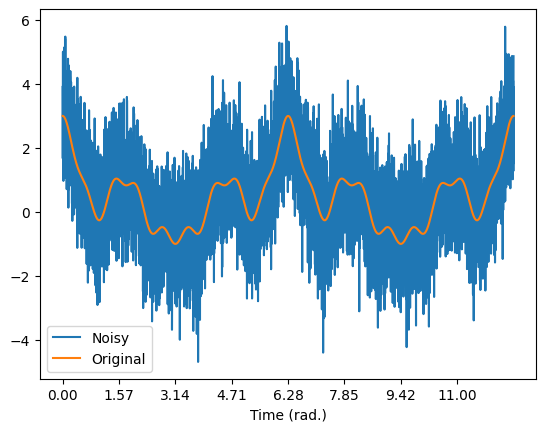

In [2]:
# create a noisy signal

N = 10001
time = np.linspace(0,4*np.pi,N)

signal = np.zeros(N)
for i in range(1,4):
  signal += np.cos(i*time)**i

noisysignal = signal + np.random.randn(N)

plt.plot(time,noisysignal, time,signal)
plt.legend(['Noisy','Original'])
plt.xlabel('Time (rad.)')
plt.xticks(np.arange(time[0],time[-1],np.pi/2))
plt.show()

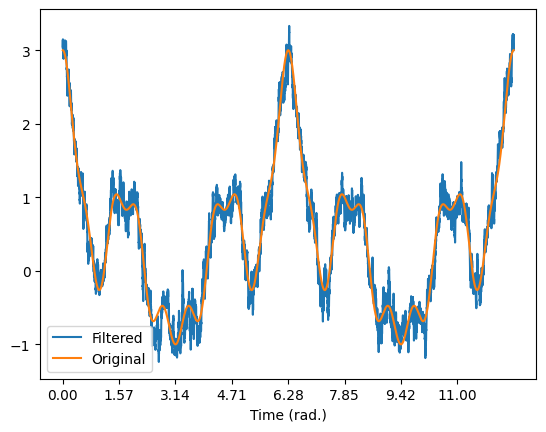

In [4]:
k = 15

filtsignal = copy.deepcopy(noisysignal)

for i in range(N):
  lowbnd = np.max((0,i-k))
  uppbnd = np.min((N,i+k))

  filtsignal[i] = np.mean(noisysignal[lowbnd:uppbnd])


# and plot
plt.plot(time,filtsignal, time,signal)
plt.legend(['Filtered','Original'])
plt.xlabel('Time (rad.)')
plt.xticks(np.arange(time[0],time[-1],np.pi/2))
plt.show()

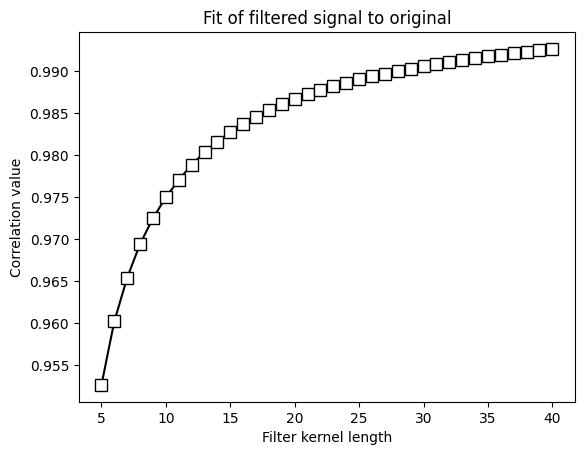

In [5]:
# mean-smoothing function, to be called later
def meansmooth(signalIn,k):
  filtsignal = copy.deepcopy(signalIn)
  for i in range(N):
    filtsignal[i] = np.mean(signalIn[ np.max((0,i-k)) : np.min((N,i+k)) ])
  return filtsignal


# range of smoothing kernels
kvals = np.arange(5,41) # 500,15
signalCorrs = []

for ki in kvals:
  # filter the signal
  newsignal = meansmooth(noisysignal,ki)
  ctmp = np.corrcoef(newsignal,signal)
  signalCorrs.append(ctmp[0,1])
  

# and plot
plt.plot(kvals,signalCorrs,'ks-',markerfacecolor='w',markersize=8)
plt.title('Fit of filtered signal to original')
plt.xlabel('Filter kernel length')
plt.ylabel('Correlation value')
plt.show()

### Gaussian convolution

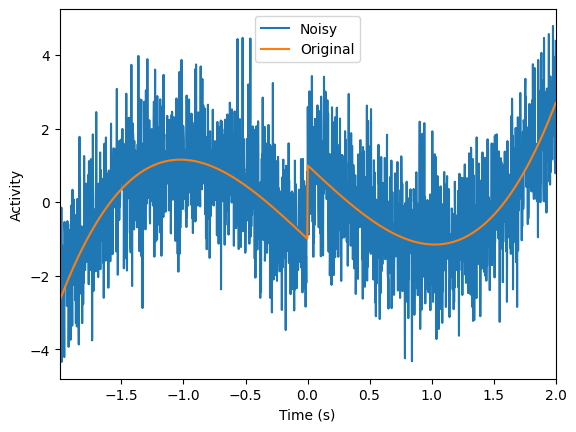

In [6]:
# create signal
srate = 512
time  = np.arange(-2,2+1/srate,1/srate)
pnts  = len(time)

signal = detrend(time**3 + np.sign(time))
noisysignal = signal + np.random.randn(pnts)*1.1

plt.plot(time,noisysignal, time,signal)
plt.xlabel('Time (s)')
plt.ylabel('Activity')
plt.legend(['Noisy','Original'])
plt.xlim(time[[1,-1]])
plt.show()

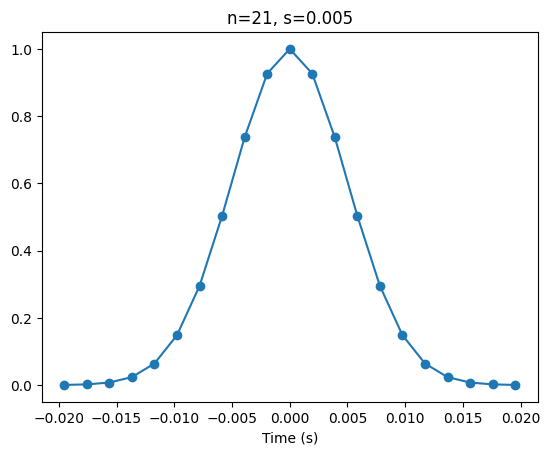

In [7]:
# create Gaussian

k = 10
x = np.arange(-k,k+1)/srate
s = .005
gkern = np.exp(-x**2 / (2*s**2))

plt.plot(x,gkern,'o-')
plt.title('n=%g, s=%g'%(2*k+1,s))
plt.xlabel('Time (s)')
plt.show()

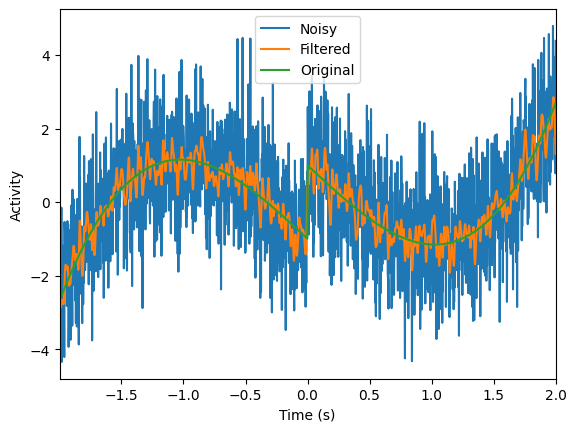

In [8]:
# run convolution
gkern = gkern / sum(gkern)
filtsig = np.convolve(noisysignal,gkern,mode='same') # input signal

# plot for comparison
plt.plot(time,noisysignal, time,filtsig, time,signal)
plt.xlabel('Time (s)')
plt.ylabel('Activity')
plt.legend(['Noisy','Filtered','Original'])
plt.xlim(time[[1,-1]])
plt.show()

In [9]:
# length vs. width of kernel

# parameter ranges
krange = np.arange(3,300,20)
srange = np.linspace(.001,.5,60)

# initialize
sseMat = np.zeros((len(krange),len(srange)))
allkernels = [[0]*len(srange) for i in range(len(krange))]

for ki in range(len(krange)):
  for si in range(len(srange)):
    # create Gaussian
    x = np.arange(-krange[ki],krange[ki]+1)/srate
    s = srange[si]
    gkern = np.exp(-x**2 / (2*s**2))

    # filter the signal
    filtsig = np.convolve(noisysignal,gkern/sum(gkern),mode='same')
    
    # compute SSE
    sseMat[ki,si] = np.sum((filtsig-signal)**2)
    
    # store Gaussians for later
    allkernels[ki][si] = gkern


<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Estela\AppData\Local\Temp\ipykernel_15884\1915102146.py:8: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$\sigma$')


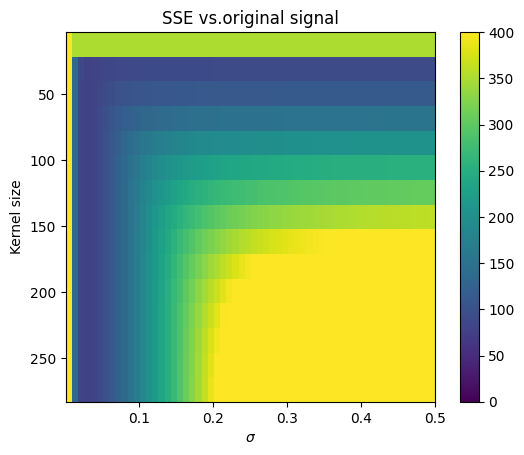

In [10]:
# image of the SSE matrix

plt.imshow(sseMat,vmin=0,vmax=400,
           extent=[srange[0],srange[-1],krange[-1],krange[0]])

plt.gca().set_aspect(1./plt.gca().get_data_ratio())
plt.colorbar()
plt.xlabel('$\sigma$')
plt.ylabel('Kernel size')
plt.title('SSE vs.original signal')
plt.show()

<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Estela\AppData\Local\Temp\ipykernel_15884\3948276471.py:14: SyntaxWarning: invalid escape sequence '\s'
  ax[kj,si].set_title('k=%g, $\sigma$=%.2f'%(krange[kidx[kj]],srange[sidx[si]]))


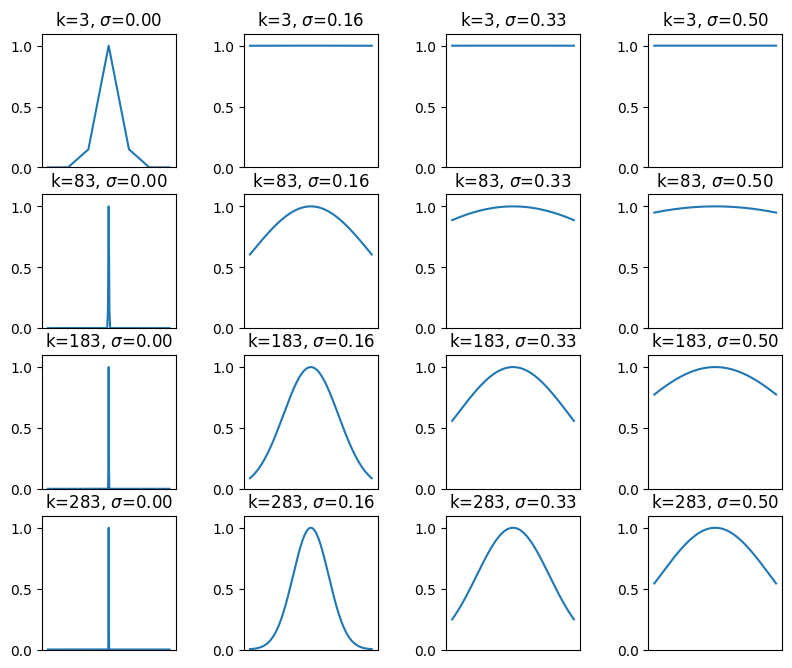

In [11]:
# plot a few non-randomly selected Gaussian kernels

fig,ax = plt.subplots(4,4,figsize=(10,8))

# 4 equally spaced points on the grid
sidx = np.linspace(0,len(srange)-1,4).astype(int)
kidx = np.linspace(0,len(krange)-1,4).astype(int)

for si in range(4):
  for kj in range(4):
    ax[kj,si].plot(allkernels[kidx[kj]][sidx[si]])
    ax[kj,si].set_xticks([])
    ax[kj,si].set_ylim([0,1.1])
    ax[kj,si].set_title('k=%g, $\sigma$=%.2f'%(krange[kidx[kj]],srange[sidx[si]]))
    ax[kj,si].set_aspect(1/ax[kj,si].get_data_ratio())

plt.show()

### Median filter

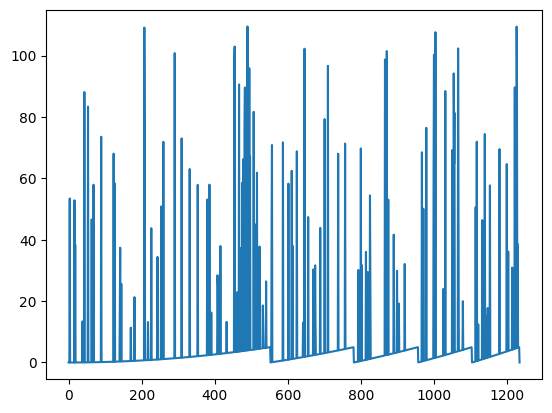

In [12]:
# create the data

pnts = 1234
signal = np.mod(np.linspace(0,5,pnts)**2,5)

# add spike noise
p = int(.1*len(signal))
spiketimes = np.random.randint(0,len(signal),p)

signal[spiketimes] = 10 + 100*np.random.rand(p)

plt.plot(signal)
plt.show()

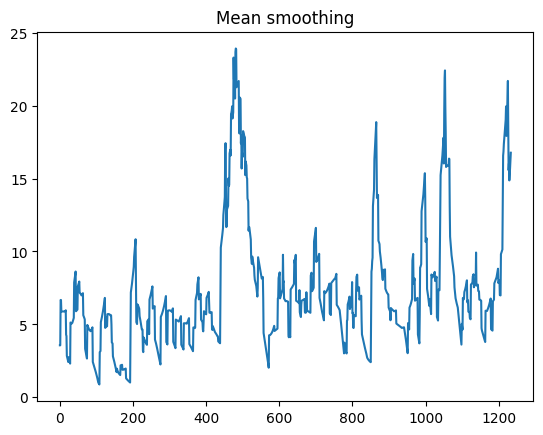

In [13]:
# try mean-smoothing
k = 15

for i in range(pnts):
  lowbnd = np.max((0,i-k))
  uppbnd = np.min((pnts,i+k))
  signal[i] = np.mean(signal[lowbnd:uppbnd])

# and plot
plt.plot(signal)
plt.title('Mean smoothing')
plt.show()

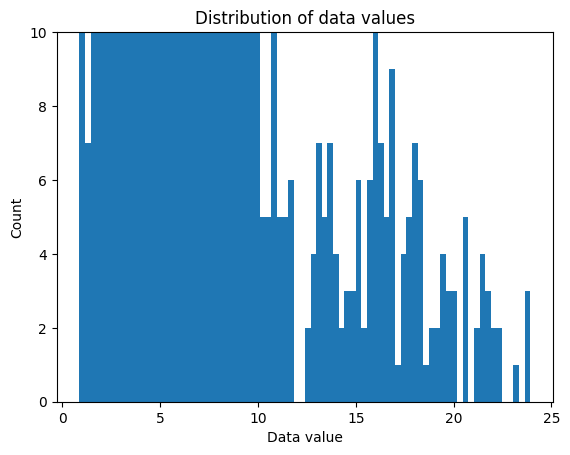

In [14]:
# find a threshold for unusually large values

plt.hist(signal,80)
plt.ylim([0,10])
plt.xlabel('Data value')
plt.ylabel('Count')
plt.title('Distribution of data values')
plt.show()

In [15]:
# threshold
thresh = 10

# find all data points above threshold
suprathreshpoints = np.where(signal>thresh)[0]
print(suprathreshpoints)
print(100*len(suprathreshpoints)/pnts)


[ 205  206  207  440  441  442  443  444  445  446  447  448  449  450
  451  452  453  454  455  456  457  458  459  460  461  462  463  464
  465  466  467  468  469  470  471  472  473  474  475  476  477  478
  479  480  481  482  483  484  485  486  487  488  489  490  491  492
  493  494  495  496  497  498  499  500  501  502  503  504  505  506
  507  508  509  510  511  512  513  514  515  516  517  518  519  520
  521  522  695  696  697  698  699  700  856  857  858  859  860  861
  862  863  864  865  866  867  868  869  870  871  872  873  874  989
  990  991  992  993  994  995  996  997  998  999 1000 1001 1002 1003
 1039 1040 1041 1042 1043 1044 1045 1046 1047 1048 1049 1050 1051 1052
 1053 1054 1055 1056 1057 1058 1059 1060 1061 1062 1063 1064 1065 1066
 1067 1068 1069 1209 1210 1211 1212 1213 1214 1215 1216 1217 1218 1219
 1220 1221 1222 1223 1224 1225 1226 1227 1228 1229 1230 1231 1232 1233]
14.748784440842787


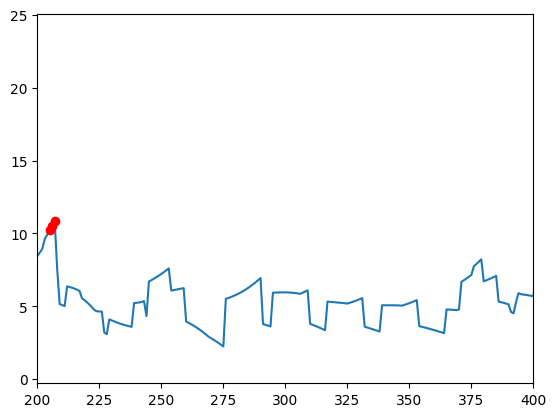

In [16]:
# let's see what it looks like
plt.plot(signal)
plt.plot(suprathreshpoints,signal[suprathreshpoints],'ro')

# zoom in
plt.xlim([200,400])
plt.show()

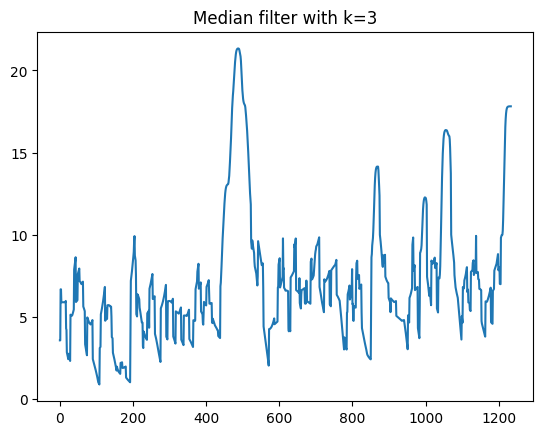

In [20]:
# apply median filter

k = 3

for i in suprathreshpoints:
  lowbnd = np.max((0,i-k))
  uppbnd = np.min((pnts,i+k))
  signal[i] = np.median(signal[lowbnd:uppbnd])

plt.plot(signal)
plt.title('Median filter with k=' + str(k))
plt.show()